In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Oct  8 16:47:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

%matplotlib inline

In [3]:
dtype = 'float32'
tf.keras.backend.set_floatx(dtype)

In [4]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype(dtype) / 255.0
y_train = y_train.astype(dtype)
X_test = X_test.astype(dtype)  / 255.0
y_test = y_test.astype(dtype)

X_train = np.reshape(X_train, (-1, 3072))
X_test = np.reshape(X_test, (-1, 3072))

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

170508288/170498071 [==============================] - 11s 0us/step


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_norm = scaler.transform(X)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_norm = np.reshape(X_norm, (-1, 32, 32, 3))
X_train_norm = np.reshape(X_train_norm, (-1, 32, 32, 3))
X_test_norm = np.reshape(X_test_norm, (-1, 32, 32, 3))

In [51]:
class Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, regularization_penalty, regularization_method):
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method

    def __call__(self, x):
        if self.regularization_method == 'weighted_l1':
            return self.weighted_l1(x)
        elif self.regularization_method == 'group_sparsity':
            return self.group_sparsity(x)
        else:
            raise NotImplementedError(f"Unknown regularization method {self.regularization_method}")
    
    def weighted_l1(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        scaling_tensor = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)
        weighted_values = scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def group_sparsity(self, x):
        # I.e. for a parameter matrix of 3 input and 5 output neurons:
        #
        # [[1., 1., 1., 1., 1.],
        #  [1., 2., 2., 1., 2.],
        #  [2., 2., 3., 1., 3.]]
        #
        # The resulting vector of group norms is [2., 2., 3., 1., 3.], therefore for
        # every output neuron, its incoming connections form a group.

        # TODO implement for Conv2D layers
        group_norms = tf.norm(x, ord=2, axis=0)
        # assert group_norms.shape[0] == x.shape[1]
        return self.regularization_penalty * tf.reduce_sum(group_norms)

    def get_config(self):
        return {'regularization_penalty': float(self.regularization_penalty)}


class ModelReference:
    def __init__(self, model):
        self.model = model


class CustomLayer(tf.keras.Model):
    def __init__(self, input_shape):
        super().__init__()

        self.inpt_shp = input_shape
    
    def configure(self, model):
        self.mr = ModelReference(model)
    
    def get_input_shape(self):
        if self.inpt_shp is not None:
            return self.inpt_shp
        
        return self.mr.model.get_layer_input_shape(self)
    
    def get_output_shape(self):
        return self.mr.model.get_layer_output_shape(self)


class Dense(CustomLayer):
    def __init__(self, units, activation, regularization_penalty=0.01, 
                 regularization_method='weighted_l1', kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros', input_shape=None, fixed_size=False):
        super().__init__(input_shape)

        self.units = units
        self.activation = activation
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.W_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        self.regularizer = Regularizer(self.regularization_penalty, self.regularization_method)
    
    def configure(self, model):
        super().configure(model)

        input_units = self.get_input_units_count()

        self.W = tf.Variable(
            name='W',
            initial_value=self.W_init(shape=(input_units, self.units), dtype=dtype),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.units,), dtype=dtype),
            trainable=True)
        
        if self.regularization_method is not None:
            self.add_loss(lambda: self.regularizer(tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)))
    
    def call(self, inputs):
        return self.A(tf.matmul(inputs, self.W) + self.b)
    
    def copy_without_regularization(self):
        # TODO fix
        copy = Dense(
            self.input_units, 
            self.units, 
            self.activation, 
            regularization_penalty=self.regularization_penalty, 
            regularization_method=None, 
            kernel_initializer=self.kernel_initializer, 
            bias_initializer=self.bias_initializer
        )
        copy.W = self.W
        copy.b = self.b
        return copy
    
    def get_input_units_count(self):
        input_shape = self.get_input_shape()
        if len(input_shape) != 1:
            raise Exception(f"Invalid input shape {input_shape}.")
        return input_shape[0]
    
    def get_size(self):
        return self.get_input_units_count(), self.W.shape[1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_W = tf.gather(self.W.value(), active_input_units_indices, axis=0)

        if self.fixed_size:
            active_output_neurons_indices = list(range(new_W.shape[1]))
        else:
            # Prune units in this layer
            weights_with_biases = tf.concat([new_W, tf.reshape(self.b.value(), (1, -1))], axis=0)
            neurons_are_active = tf.math.reduce_max(tf.abs(weights_with_biases), axis=0) >= threshold
            active_output_neurons_indices = tf.reshape(tf.where(neurons_are_active), (-1,))
            
            new_W = tf.gather(new_W, active_output_neurons_indices, axis=1)
            new_b = tf.gather(self.b.value(), active_output_neurons_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        return active_output_neurons_indices
    
    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            W_growth = self.W_init(shape=(self.W.shape[0] + n_new_input_units, self.W.shape[1]), dtype=dtype)[-n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_W = tf.concat([self.W.value(), W_growth], axis=0)
        else:
            new_W = self.W.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_W.shape[1] * percentage))
            W_growth = self.W_init(shape=(new_W.shape[0], new_W.shape[1] + n_new_output_units), dtype=dtype)[:, -n_new_output_units:] * scaling_factor
            b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
            new_W = tf.concat([new_W, W_growth], axis=1)
            new_b = tf.concat([self.b.value(), b_growth], axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        return n_new_output_units
    
    def get_param_string():
        param_string = ""
        weights_with_bias = tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)
        max_parameters = tf.math.reduce_max(tf.abs(weights_with_bias), axis=0).numpy()
        magnitudes = np.floor(np.log10(max_parameters))
        for m in magnitudes:
            if m > 0:
                m = 0
            param_string += str(int(-m))
        return param_string


class Conv2D(CustomLayer):
    def __init__(self, filters, filter_size, activation, strides=(1, 1), 
                 padding='SAME', regularization_penalty=0.01, 
                 regularization_method='weighted_l1', kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', input_shape=None, fixed_size=False):
        super().__init__(input_shape)
    
        self.filters = filters
        self.filter_size = filter_size
        self.activation = activation
        self.strides = strides
        self.padding = padding
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.F_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        self.regularizer = Regularizer(self.regularization_penalty, self.regularization_method)
    
    def configure(self, model):
        super().configure(model)

        input_filters = self.get_input_filters_count()

        self.F = tf.Variable(
            name='F',
            initial_value=self.F_init(
                shape=(self.filter_size[0], self.filter_size[1], input_filters, self.filters), dtype=dtype
            ),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.filters,), dtype=dtype),
            trainable=True)

        if self.regularization_method is not None:
            self.add_loss(lambda: self.regularizer(tf.concat([tf.reshape(self.F, (-1, self.F.shape[-1])), tf.reshape(self.b, (1, -1))], axis=0)))
    
    def call(self, inputs):
        y = tf.nn.conv2d(inputs, self.F, strides=self.strides, padding=self.padding)
        y = tf.nn.bias_add(y, self.b)
        y = self.A(y)
        return y
    
    def copy_without_regularization(self):
        # TODO fix
        copy = Conv2D(
            self.input_filters,
            self.filters,
            self.filter_size,
            self.activation, 
            strides=self.strides, 
            padding=self.padding, 
            kernel_initializer=self.kernel_initializer, 
            bias_initializer=self.bias_initializer 
        )
        copy.F = self.F
        copy.b = self.b
        return copy
    
    def get_input_filters_count(self):
        input_shape = self.get_input_shape()
        return input_shape[-1]
    
    def get_size(self):
        return self.get_input_filters_count(), self.F.shape[-1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_F = tf.gather(self.F.value(), active_input_units_indices, axis=-2)

        if self.fixed_size:
            active_output_filters_indices = list(range(new_F.shape[-1]))
        else:
            # Prune units in this layer
            F_reduced_max = tf.reshape(tf.math.reduce_max(tf.abs(new_F), axis=(0, 1, 2)), (1, -1))
            F_reduced_max_with_biases = tf.concat([F_reduced_max, tf.reshape(self.b.value(), (1, -1))], axis=0)
            filters_are_active = tf.math.reduce_max(tf.abs(F_reduced_max_with_biases), axis=0) >= threshold
            active_output_filters_indices = tf.reshape(tf.where(filters_are_active), (-1,))
            
            new_F = tf.gather(new_F, active_output_filters_indices, axis=-1)
            new_b = tf.gather(self.b.value(), active_output_filters_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        return active_output_filters_indices

    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            F_growth = self.F_init(shape=(self.F.shape[0], self.F.shape[1], self.F.shape[2] + n_new_input_units, self.F.shape[3]), dtype=dtype)[:, :, -n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_F = tf.concat([self.F.value(), F_growth], axis=-2)
        else:
            new_F = self.F.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_F.shape[-1] * percentage))
            F_growth = self.F_init(shape=(new_F.shape[0], new_F.shape[1], new_F.shape[2], new_F.shape[3] + n_new_output_units), dtype=dtype)[:, :, :, -n_new_output_units:] * scaling_factor
            b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
            new_F = tf.concat([new_F, F_growth], axis=-1)
            new_b = tf.concat([self.b.value(), b_growth], axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        return n_new_output_units

    def get_param_string():
        param_string = ""
        # TODO
        return param_string


class Flatten(tf.keras.Model):
    def call(self, inputs):
        return tf.reshape(tf.transpose(inputs, perm=[0, 3, 1, 2]), (inputs.shape[0], -1))


class Sequential(tf.keras.Model):
    def __init__(self, layers, activation=None):
        super().__init__()
        
        self.lrs = list()
        for layer in layers:
            self.lrs.append(layer)
            if isinstance(layer, CustomLayer):
                layer.configure(self)

    def call(self, inputs):
        x = inputs
        for layer in self.lrs:
            x = layer(x)
        return x
    
    def get_layer_input_shape(self, target_layer):
        input = np.random.normal(size=(1,) + self.lrs[0].inpt_shp)
        for layer in self.lrs:
            if layer is target_layer:
                return tuple(input.shape[1:])
            input = layer(input)
        raise Exception("Layer not found in the model.")

    def get_layer_output_shape(self, target_layer):
        input = np.random.normal(size=(1,) + self.lrs[0].inpt_shp)
        for layer in self.lrs:
            output = layer(input)
            if layer is target_layer:
                return tuple(output.shape[1:])
            input = output
        raise Exception("Layer not found in the model.")
    
    def get_layer_sizes(self):
        """
        Returns the sizes of all layers in the model, including the input and output layer.
        """
        layer_sizes = list()
        first_layer = True
        for l in range(len(self.lrs)):
            layer = self.lrs[l]
            if isinstance(layer, CustomLayer):
                layer_size = layer.get_size()
                if first_layer:
                    layer_sizes.append(layer_size[0])
                    first_layer = False
                layer_sizes.append(layer_size[1])
        return layer_sizes
    
    def get_hidden_layer_sizes(self):
        return self.get_layer_sizes()[1:-1]
    
    def remove_regularization(self):
        # for l in range(len(self.lrs)):
        #     layer = self.lrs[l]
        #     if isinstance(layer, CustomLayer):
        #         self.lrs[l] = layer.copy_without_regularization()
        self.set_regularization_penalty(0.)
    
    def get_regularization_penalty(self):
        return self.lrs[-2].regularizer.regularization_penalty
    
    def set_regularization_penalty(self, regularization_penalty):
        for layer in self.lrs:
            if isinstance(layer, CustomLayer) and not layer.fixed_size:
                layer.regularizer.regularization_penalty = regularization_penalty
    
    def prune(self, threshold=0.001):
        # for l in range(len(self.lrs) - 1):
        #     layer1 = self.lrs[l]
        #     layer2 = self.lrs[l + 1]
            
        #     W1 = layer1.W.value()
        #     b1 = layer1.b.value()
        #     W2 = layer2.W.value()

        #     weights_with_biases = tf.concat([W1, tf.reshape(b1, (1, -1))], axis=0)
        #     neurons_are_active = tf.math.reduce_max(tf.abs(weights_with_biases), axis=0) >= threshold
        #     active_neurons_indices = tf.reshape(tf.where(neurons_are_active), (-1,))
            
        #     new_W1 = tf.gather(W1, active_neurons_indices, axis=1)
        #     new_b1 = tf.gather(b1, active_neurons_indices, axis=0)
        #     new_W2 = tf.gather(W2, active_neurons_indices, axis=0)

        #     layer1.W = tf.Variable(name='W', initial_value=new_W1, trainable=True)
        #     layer1.b = tf.Variable(name='b', initial_value=new_b1, trainable=True)
        #     layer2.W = tf.Variable(name='W', initial_value=new_W2, trainable=True)
        input_shape = self.lrs[0].get_input_shape()
        n_input_units = input_shape[-1]
        active_units_indices = list(range(n_input_units))

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, CustomLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = last_custom_layer.get_output_shape()
                        active_units_indices = self.convert_channel_indices_to_flattened_indices(active_units_indices, convolutional_shape)
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                active_units_indices = layer.prune(threshold, active_units_indices)
                last_custom_layer = layer
    
    def grow(self, percentage, min_new_neurons=5, scaling_factor=0.001):   
        # for l in range(len(self.lrs) - 1):
        #     layer1 = self.lrs[l]
        #     layer2 = self.lrs[l + 1]
       
        #     W1 = layer1.W.value()
        #     b1 = layer1.b.value()
        #     W2 = layer2.W.value()

        #     n_new_neurons = max(min_new_neurons, int(W1.shape[1] * percentage))

        #     W1_growth = layer1.W_init(shape=(W1.shape[0], W1.shape[1] + n_new_neurons), dtype=dtype)[:, -n_new_neurons:] * scaling_factor
        #     b1_growth = layer1.b_init(shape=(n_new_neurons,), dtype=dtype)
        #     W2_growth = layer2.W_init(shape=(W2.shape[0] + n_new_neurons, W2.shape[1]), dtype=dtype)[-n_new_neurons:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.

        #     new_W1 = tf.concat([W1, W1_growth], axis=1)
        #     new_b1 = tf.concat([b1, b1_growth], axis=0)
        #     new_W2 = tf.concat([W2, W2_growth], axis=0)

        #     layer1.W = tf.Variable(name='W1', initial_value=new_W1, trainable=True)
        #     layer1.b = tf.Variable(name='b1', initial_value=new_b1, trainable=True)
        #     layer2.W = tf.Variable(name='W2', initial_value=new_W2, trainable=True)
        n_new_units = 0

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, CustomLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = last_custom_layer.get_output_shape()
                        n_new_units = n_new_units * convolutional_shape[0] * convolutional_shape[1]
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                n_new_units = layer.grow(n_new_units, percentage, min_new_units=min_new_neurons, scaling_factor=scaling_factor)
                last_custom_layer = layer
    
    @staticmethod
    def convert_channel_indices_to_flattened_indices(channel_indices, convolutional_shape):
        dense_indices = list()
        units_per_channel = convolutional_shape[0] * convolutional_shape[1]
        for channel_index in channel_indices:
            for iter in range(units_per_channel):
                dense_indices.append(channel_index * units_per_channel + iter)
        return dense_indices
    
    def print_neurons(self):
        for layer in self.lrs[:-1]:
            print(layer.get_param_string())
    
    def evaluate(self, x, y, summed_training_loss, summed_training_accuracy, val_dataset):
        # Calculate training loss and accuracy
        if summed_training_loss is not None:
            loss = summed_training_loss / x.shape[0]
        else:
            loss = None
        
        if summed_training_accuracy is not None:
            accuracy = summed_training_accuracy / x.shape[0]
        else:
            accuracy = None
        
        # Calculate val loss and accuracy
        summed_val_loss = 0
        summed_val_accuracy = 0
        n_val_instances = 0
        
        for step, (x_batch, y_batch) in enumerate(val_dataset):
            y_pred = self(x_batch)
            summed_val_loss += tf.reduce_sum(tf.keras.losses.sparse_categorical_crossentropy(y_batch, y_pred))
            summed_val_accuracy += float(tf.reduce_sum(tf.keras.metrics.sparse_categorical_accuracy(y_batch, y_pred)))
            n_val_instances += x_batch.shape[0]
        
        val_loss = summed_val_loss / n_val_instances
        val_accuracy = summed_val_accuracy / n_val_instances

        return loss, accuracy, val_loss, val_accuracy
    
    def print_epoch_statistics(self, x, y, summed_training_loss, summed_training_accuracy, val_dataset, print_neurons):
        loss, accuracy, val_loss, val_accuracy = self.evaluate(x, y, summed_training_loss, summed_training_accuracy, val_dataset)
        print(f"loss: {loss} - accuracy: {accuracy} - val_loss: {val_loss} - val_accuracy: {val_accuracy} - penalty: {model.get_regularization_penalty()}")
        hidden_layer_sizes = self.get_hidden_layer_sizes()
        print(f"hidden layer sizes: {hidden_layer_sizes}, total units: {sum(hidden_layer_sizes)}")
        if print_neurons:
            self.print_neurons()
    
    def update_history(self, x, y, summed_loss, summed_accuracy, val_dataset, history):
        loss, accuracy, val_loss, val_accuracy = self.evaluate(x, y, summed_loss, summed_accuracy, val_dataset)
        history['loss'].append(loss)
        history['accuracy'].append(accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

    def fit(self, x, y, optimizer, epochs, self_scaling_epochs, batch_size, min_new_neurons, validation_data, pruning_threshold=0.001, 
            regularization_penalty_multiplier=1., stall_coefficient=1, growth_percentage=0.2, mini_epochs_per_epoch=1, verbose=True, print_neurons=False):
        train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

        val_dataset = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)

        history = {
            'loss': list(),
            'accuracy': list(),
            'val_loss': list(),
            'val_accuracy': list(),
        }

        best_val_loss = np.inf
        training_stalled = False
        for epoch in range(epochs):
            summed_loss = 0
            summed_accuracy = 0

            if verbose:
                print("##########################################################")
                print(f"Epoch {epoch + 1}/{epochs}")

            if epoch < self_scaling_epochs:
                if verbose:
                    print("Before growing:")
                    self.print_epoch_statistics(x, y, None, None, val_dataset, print_neurons)

                loss, accuracy, val_loss, val_accuracy = self.evaluate(x, y, summed_loss, summed_accuracy, val_dataset)
                if regularization_penalty_multiplier != 1. and val_loss >= best_val_loss * stall_coefficient:
                    if not training_stalled:
                        penalty = self.get_regularization_penalty() * regularization_penalty_multiplier
                        print("Changing penalty...")
                        # TODO this must be modified, penalty can differ for each layer
                        self.set_regularization_penalty(penalty)
                        training_stalled = True
                else:
                    best_val_loss = val_loss
                    training_stalled = False

                self.grow(percentage=growth_percentage, min_new_neurons=min_new_neurons, scaling_factor=pruning_threshold)
                if verbose:
                    print("After growing:")
                    self.print_epoch_statistics(x, y, None, None, val_dataset, print_neurons)
            
            if epoch == self_scaling_epochs:
                self.remove_regularization()

            for mini_epoch in range(mini_epochs_per_epoch):
                for step, (x_batch, y_batch) in enumerate(train_dataset):
                    with tf.GradientTape() as tape:
                        y_pred = self(x_batch, training=True)
                        raw_loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, y_pred)
                        loss_value = tf.reduce_mean(raw_loss)
                        loss_value += sum(self.losses)  # Add losses registered by model.add_loss

                        summed_loss += tf.reduce_sum(raw_loss)
                        summed_accuracy += float(tf.reduce_sum(tf.keras.metrics.sparse_categorical_accuracy(y_batch, y_pred)))

                    grads = tape.gradient(loss_value, self.trainable_variables)
                    optimizer.apply_gradients(zip(grads, self.trainable_variables))
            
            if epoch < self_scaling_epochs:
                if verbose:
                    print("Before pruning:")
                    self.print_epoch_statistics(x, y, summed_loss, summed_accuracy, val_dataset, print_neurons)
                self.prune(threshold=pruning_threshold)
                if verbose:
                    print("After pruning:")
                    self.print_epoch_statistics(x, y, None, None, val_dataset, print_neurons)
            else:
                if verbose:
                    self.print_epoch_statistics(x, y, summed_loss, summed_accuracy, val_dataset, print_neurons)
            
            self.update_history(x, y, summed_loss, summed_accuracy, val_dataset, history)

        return history

# Convolutions

In [ ]:
epochs = 20
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Dense(20, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal', input_shape=X_train_norm[0, :].shape),
        Dense(20, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(20, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(20, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
Before growing:
loss: None - accuracy: None - val_loss: 2.847022533416748 - val_accuracy: 0.0938 - penalty: 1e-06
hidden layer sizes: [20, 20, 20, 20], total units: 80
After growing:
loss: None - accuracy: None - val_loss: 2.84702205657959 - val_accuracy: 0.0938 - penalty: 1e-06
hidden layer sizes: [40, 40, 40, 40], total units: 160
Before pruning:
loss: 1.9452203512191772 - accuracy: 0.32256 - val_loss: 1.7487735748291016 - val_accuracy: 0.3872 - penalty: 1e-06
hidden layer sizes: [40, 40, 40, 40], total units: 160
After pruning:
loss: None - accuracy: None - val_loss: 1.7487735748291016 - val_accuracy: 0.3872 - penalty: 1e-06
hidden layer sizes: [40, 40, 40, 40], total units: 160
##########################################################
Epoch 2/20
Before growing:
loss: None - accuracy: None - val_loss: 1.7487735748291016 - val_accuracy: 0.3872 - penalty: 1e-06
hidden layer sizes: [40, 40, 40, 40], total units: 160

{'accuracy': [0.32256,
  0.40406,
  0.43732,
  0.46044,
  0.47494,
  0.48604,
  0.49738,
  0.50546,
  0.51368,
  0.51908,
  0.52698,
  0.53322,
  0.53872,
  0.54382,
  0.55034,
  0.55546,
  0.55652,
  0.5622,
  0.56502,
  0.56912],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.9452204>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.6932038>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5950701>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5310634>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.4861519>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.4510244>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.422027>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3944101>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3739022>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.353438>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3362911>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3206266>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3053122>,
  <tf.Tensor: shape=(

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        # tf.keras.layers.Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

# 74.5 % vs 71.5 % accuracy in the following two models - 3 % boost! (output lost)

## Dynamic models

In [ ]:
epochs = 20
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
Before growing:
loss: None - accuracy: None - val_loss: 2.963027238845825 - val_accuracy: 0.0795 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
After growing:
loss: None - accuracy: None - val_loss: 2.963027238845825 - val_accuracy: 0.0795 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
Before pruning:
loss: 1.8671212196350098 - accuracy: 0.38654 - val_loss: 1.3841943740844727 - val_accuracy: 0.5051 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
After pruning:
loss: None - accuracy: None - val_loss: 1.3840810060501099 - val_accuracy: 0.5043 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 257], total units: 1025
##########################################################
Epoch 2/20
Before growing:
loss: None - accuracy: None - val_loss: 1.3840810060501099 - val_accuracy: 0.5043 - penalty: 1e-06
hidden layer

{'accuracy': [0.38654,
  0.45996,
  0.5233,
  0.56528,
  0.60158,
  0.6377,
  0.66296,
  0.68452,
  0.69782,
  0.71044,
  0.72276,
  0.72994,
  0.73536,
  0.74644,
  0.75044,
  0.75626,
  0.75946,
  0.7638,
  0.76808,
  0.77302],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.8671212>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5167488>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3350378>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.2161906>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1187294>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0229794>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.95301104>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.89190626>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8516693>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.81481975>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7849943>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7655342>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7458458>,
  <tf.Tensor: shap

In [ ]:
epochs = 30
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/30
Before growing:
loss: None - accuracy: None - val_loss: 2.981550693511963 - val_accuracy: 0.1077 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
After growing:
loss: None - accuracy: None - val_loss: 2.9815502166748047 - val_accuracy: 0.1077 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
Before pruning:
loss: 1.9397608041763306 - accuracy: 0.37282 - val_loss: 1.468695878982544 - val_accuracy: 0.4728 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
After pruning:
loss: None - accuracy: None - val_loss: 1.466652512550354 - val_accuracy: 0.4743 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 257], total units: 1025
##########################################################
Epoch 2/30
Before growing:
loss: None - accuracy: None - val_loss: 1.466652512550354 - val_accuracy: 0.4743 - penalty: 1e-06
hidden layer s

In [ ]:
epochs = 20
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
Before growing:
loss: None - accuracy: None - val_loss: 2.965449810028076 - val_accuracy: 0.0943 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
After growing:
loss: None - accuracy: None - val_loss: 2.9654500484466553 - val_accuracy: 0.0943 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
Before pruning:
loss: 1.9078271389007568 - accuracy: 0.38218 - val_loss: 1.427015781402588 - val_accuracy: 0.4892 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
After pruning:
loss: None - accuracy: None - val_loss: 1.426162838935852 - val_accuracy: 0.4891 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 261], total units: 1029
##########################################################
Epoch 2/20
Before growing:
loss: None - accuracy: None - val_loss: 1.426162838935852 - val_accuracy: 0.4891 - penalty: 1e-06
hidden layer s

{'accuracy': [0.38218,
  0.47094,
  0.52314,
  0.56054,
  0.591,
  0.6224,
  0.64552,
  0.66534,
  0.68246,
  0.69776,
  0.71072,
  0.71876,
  0.73006,
  0.73512,
  0.7463,
  0.74762,
  0.75674,
  0.75832,
  0.7673,
  0.76898],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.9078271>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.4895903>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3357962>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.2331066>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1451589>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0575879>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9986784>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9431844>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8991598>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.84754854>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8216924>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.79103124>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7626462>,
  <tf.Tensor: shape=(

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
Before growing:
loss: None - accuracy: None - val_loss: 2.840655565261841 - val_accuracy: 0.1002 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
After growing:
loss: None - accuracy: None - val_loss: 2.84065580368042 - val_accuracy: 0.1002 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
Before pruning:
loss: 1.9883681535720825 - accuracy: 0.36158 - val_loss: 1.4862158298492432 - val_accuracy: 0.476 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
After pruning:
loss: None - accuracy: None - val_loss: 1.4863176345825195 - val_accuracy: 0.4759 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
##########################################################
Epoch 2/20
Before growing:
loss: None - accuracy: None - val_loss: 1.4863176345825195 - val_accuracy: 0.4759 - penalty: 1e-06
hidden layer s

{'accuracy': [0.36158,
  0.4584,
  0.52154,
  0.55994,
  0.58706,
  0.61628,
  0.64598,
  0.67044,
  0.69346,
  0.7153,
  0.72814,
  0.7413,
  0.75176,
  0.76094,
  0.77142,
  0.77972,
  0.78484,
  0.79202,
  0.79806,
  0.80034],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.9883682>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5261092>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3418874>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.232293>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1574098>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0810536>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.99908876>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9280333>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8665343>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.81279296>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7686487>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7316875>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.70048416>,
  <tf.Tensor: shape

In [ ]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
Before growing:
loss: None - accuracy: None - val_loss: 0.7751069068908691 - val_accuracy: 0.7361 - penalty: 1e-06
hidden layer sizes: [174, 54, 71, 200, 279], total units: 778
After growing:
loss: None - accuracy: None - val_loss: 0.7751069664955139 - val_accuracy: 0.7361 - penalty: 1e-06
hidden layer sizes: [208, 74, 91, 240, 334], total units: 947
Before pruning:
loss: 0.5426346063613892 - accuracy: 0.80752 - val_loss: 0.7737799882888794 - val_accuracy: 0.7273 - penalty: 1e-06
hidden layer sizes: [208, 74, 91, 240, 334], total units: 947
After pruning:
loss: None - accuracy: None - val_loss: 0.7737587690353394 - val_accuracy: 0.7271 - penalty: 1e-06
hidden layer sizes: [168, 52, 68, 196, 273], total units: 757
##########################################################
Epoch 2/20
Before growing:
loss: None - accuracy: None - val_loss: 0.7737587690353394 - val_accuracy: 0.7271 - penalty: 1e-06
hidden layer sizes: [1

{'accuracy': [0.80752,
  0.80988,
  0.81346,
  0.8191,
  0.82134,
  0.8247,
  0.82708,
  0.83188,
  0.83242,
  0.83558,
  0.83914,
  0.84106,
  0.84198,
  0.84404,
  0.84692,
  0.84924,
  0.84984,
  0.85484,
  0.8535,
  0.8566],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.5426346>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.53282803>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5252961>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5142059>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.50391924>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.49207613>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.48363596>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.47302473>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.47196797>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.4619729>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.45086032>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.44746807>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.4454068>,
  <tf.Tensor: 

In [ ]:
epochs = 30
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/30
Before growing:
loss: None - accuracy: None - val_loss: 2.9966039657592773 - val_accuracy: 0.095 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
After growing:
loss: None - accuracy: None - val_loss: 2.9966037273406982 - val_accuracy: 0.095 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
Before pruning:
loss: 1.9035162925720215 - accuracy: 0.38132 - val_loss: 1.4311473369598389 - val_accuracy: 0.4863 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
After pruning:
loss: None - accuracy: None - val_loss: 1.4304295778274536 - val_accuracy: 0.488 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
##########################################################
Epoch 2/30
Before growing:
loss: None - accuracy: None - val_loss: 1.4304295778274536 - val_accuracy: 0.488 - penalty: 1e-06
hidden layer s

{'accuracy': [0.38132,
  0.47052,
  0.53864,
  0.57584,
  0.61424,
  0.64546,
  0.66984,
  0.68944,
  0.70474,
  0.719,
  0.72956,
  0.73654,
  0.74674,
  0.75508,
  0.75548,
  0.76352,
  0.76712,
  0.77214,
  0.77766,
  0.77822,
  0.76752,
  0.81886,
  0.84902,
  0.87342,
  0.89744,
  0.91382,
  0.93306,
  0.94566,
  0.95534,
  0.96172],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.9035163>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.4815971>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.2890013>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1844859>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.081236>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9936506>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9322214>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8767426>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8339406>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.79099524>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7663811>,
  <tf.Tensor: shape=(), 

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/30
Before growing:
loss: None - accuracy: None - val_loss: 2.983743667602539 - val_accuracy: 0.1149 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
After growing:
loss: None - accuracy: None - val_loss: 2.983743906021118 - val_accuracy: 0.1149 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
Before pruning:
loss: 1.9288136959075928 - accuracy: 0.37844 - val_loss: 1.4544951915740967 - val_accuracy: 0.4809 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 307], total units: 1227
After pruning:
loss: None - accuracy: None - val_loss: 1.4529860019683838 - val_accuracy: 0.4821 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 256], total units: 1024
##########################################################
Epoch 2/30
Before growing:
loss: None - accuracy: None - val_loss: 1.4529860019683838 - val_accuracy: 0.4821 - penalty: 1e-06
hidden layer

{'accuracy': [0.37844,
  0.46592,
  0.53098,
  0.5748,
  0.60972,
  0.6425,
  0.66636,
  0.68794,
  0.70252,
  0.71222,
  0.72336,
  0.73368,
  0.73852,
  0.7498,
  0.75436,
  0.76042,
  0.7648,
  0.7687,
  0.7746,
  0.7785,
  0.76604,
  0.815,
  0.8464,
  0.8779,
  0.90406,
  0.92654,
  0.94354,
  0.95464,
  0.96162,
  0.96782],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.9288137>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5003464>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3108245>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1894413>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.090963>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.006982>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.93893117>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8841296>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.83872783>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8099547>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.77984107>,
  <tf.Tensor: shape=(), dtype=fl

## Static models

In [ ]:
epochs = 20
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
# Final layer sizes of dynamic models
[131, 51, 72, 277, 438]
[130, 45, 88, 244, 434]
[107, 51, 58, 212, 310]

### Layer sizes set to the architecture discovered by auto-sizing 

In [ ]:
%%time

model = Sequential([
        Conv2D(130, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(50, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(80, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(250, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(430, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 3.542296886444092 - accuracy: 0.10588 - val_loss: 2.349604606628418 - val_accuracy: 0.1 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 2/20
loss: 2.3350794315338135 - accuracy: 0.10072 - val_loss: 2.341313362121582 - val_accuracy: 0.1002 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 3/20
loss: 2.322622299194336 - accuracy: 0.11064 - val_loss: 2.151273727416992 - val_accuracy: 0.1587 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 4/20
loss: 2.028930187225342 - accuracy: 0.1828 - val_loss: 1.8920965194702148 - val_accuracy: 0.1908 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################

In [ ]:
%%time

model = Sequential([
        Conv2D(130, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(50, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(80, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(250, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(430, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 2.307016611099243 - accuracy: 0.36996 - val_loss: 1.4811290502548218 - val_accuracy: 0.457 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 2/20
loss: 1.4038615226745605 - accuracy: 0.49278 - val_loss: 1.2863517999649048 - val_accuracy: 0.5352 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 3/20
loss: 1.2491425275802612 - accuracy: 0.55084 - val_loss: 1.1936345100402832 - val_accuracy: 0.5744 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 4/20
loss: 1.1316972970962524 - accuracy: 0.59534 - val_loss: 1.1694689989089966 - val_accuracy: 0.5793 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##################

In [ ]:
%%time

model = Sequential([
        Conv2D(130, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(50, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(80, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(250, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(430, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 1.9652268886566162 - accuracy: 0.39594 - val_loss: 1.4078832864761353 - val_accuracy: 0.4997 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 2/20
loss: 1.3558696508407593 - accuracy: 0.51694 - val_loss: 1.286001443862915 - val_accuracy: 0.5464 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 3/20
loss: 1.2024716138839722 - accuracy: 0.57148 - val_loss: 1.1833745241165161 - val_accuracy: 0.5795 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 4/20
loss: 1.061343789100647 - accuracy: 0.6232 - val_loss: 1.1501379013061523 - val_accuracy: 0.5953 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
###################

In [ ]:
%%time

model = Sequential([
        Conv2D(130, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(50, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(80, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(250, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(430, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 2.064971685409546 - accuracy: 0.3657 - val_loss: 1.4674673080444336 - val_accuracy: 0.477 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 2/20
loss: 1.4317291975021362 - accuracy: 0.49284 - val_loss: 1.3502579927444458 - val_accuracy: 0.5144 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 3/20
loss: 1.2809815406799316 - accuracy: 0.5453 - val_loss: 1.278853416442871 - val_accuracy: 0.5474 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
##########################################################
Epoch 4/20
loss: 1.1600797176361084 - accuracy: 0.58854 - val_loss: 1.1908364295959473 - val_accuracy: 0.5767 - penalty: 0.0
hidden layer sizes: [130, 50, 80, 250, 430], total units: 940
#####################

### Layer sizes set manually

In [ ]:
%%time

model = Sequential([
        Conv2D(3, 96, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(96, 96, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(96, 192, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal'),
        Conv2D(96, 192, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(12288, 256, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(256, 10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/25
loss: 2.1398861408233643 - accuracy: 0.39144 - val_loss: 1.3741620779037476 - val_accuracy: 0.5007 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 2/25
loss: 1.3535252809524536 - accuracy: 0.51546 - val_loss: 1.268190860748291 - val_accuracy: 0.5486 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 3/25
loss: 1.1914558410644531 - accuracy: 0.5725 - val_loss: 1.166611671447754 - val_accuracy: 0.5835 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 4/25
loss: 1.0351282358169556 - accuracy: 0.63084 - val_loss: 1.087954044342041 - val_accuracy: 0.623 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
#####################

In [ ]:
%%time

model = Sequential([
        Conv2D(96, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(96, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 2.116030216217041 - accuracy: 0.38428 - val_loss: 1.3876560926437378 - val_accuracy: 0.4998 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 2/20
loss: 1.360109567642212 - accuracy: 0.5092 - val_loss: 1.2392711639404297 - val_accuracy: 0.5579 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 3/20
loss: 1.202415108680725 - accuracy: 0.56706 - val_loss: 1.117976427078247 - val_accuracy: 0.5957 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 4/20
loss: 1.0698447227478027 - accuracy: 0.6183 - val_loss: 1.0646827220916748 - val_accuracy: 0.6295 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
######################

### Lower learning rates

In [ ]:
%%time

model = Sequential([
        Conv2D(96, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(96, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 3.6364753246307373 - accuracy: 0.13834 - val_loss: 2.038997173309326 - val_accuracy: 0.1937 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 2/20
loss: 1.8863511085510254 - accuracy: 0.24728 - val_loss: 1.6929947137832642 - val_accuracy: 0.3369 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 3/20
loss: 1.5627237558364868 - accuracy: 0.40592 - val_loss: 1.4371005296707153 - val_accuracy: 0.4556 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 4/20
loss: 1.4159406423568726 - accuracy: 0.47122 - val_loss: 1.3222863674163818 - val_accuracy: 0.5077 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
#################

In [ ]:
%%time

model = Sequential([
        Conv2D(96, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(96, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 1.9364395141601562 - accuracy: 0.37422 - val_loss: 1.4458012580871582 - val_accuracy: 0.485 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 2/20
loss: 1.4242712259292603 - accuracy: 0.49284 - val_loss: 1.3421002626419067 - val_accuracy: 0.5156 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 3/20
loss: 1.289955735206604 - accuracy: 0.54334 - val_loss: 1.2476561069488525 - val_accuracy: 0.5556 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
##########################################################
Epoch 4/20
loss: 1.170866847038269 - accuracy: 0.58414 - val_loss: 1.1811169385910034 - val_accuracy: 0.5738 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 256], total units: 832
###################

## Cross validation

In [ ]:
epochs = 35
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    history = model.fit(xtrain, ytrain, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(xtest, ytest), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7553, layer sizes: [3, 132, 58, 74, 266, 444, 10]
Run 1 completed, best val accuracy: 0.7542, layer sizes: [3, 125, 51, 69, 275, 427, 10]
Run 2 completed, best val accuracy: 0.7571, layer sizes: [3, 135, 46, 76, 269, 446, 10]
Run 3 completed, best val accuracy: 0.7636, layer sizes: [3, 135, 59, 77, 257, 410, 10]
Run 4 completed, best val accuracy: 0.7635, layer sizes: [3, 130, 39, 84, 266, 469, 10]
Run 5 completed, best val accuracy: 0.7495, layer sizes: [3, 127, 52, 54, 279, 403, 10]
val accuracies: [0.7553, 0.7542, 0.7571, 0.7636, 0.7635, 0.7495]
mean val accuracy: 0.7572
mean layer sizes: [3.0, 130.66666666666666, 50.833333333333336, 72.33333333333333, 268.6666666666667, 433.1666666666667, 10.0]
CPU times: user 44min 48s, sys: 34.8 s, total: 45min 23s
Wall time: 52min 53s


In [ ]:
epochs = 50
self_scaling_epochs = 25
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    history = model.fit(xtrain, ytrain, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(xtest, ytest), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7643, layer sizes: [3, 98, 48, 75, 263, 481, 10]
Run 1 completed, best val accuracy: 0.7576, layer sizes: [3, 119, 40, 72, 269, 470, 10]
Run 2 completed, best val accuracy: 0.7596, layer sizes: [3, 119, 48, 78, 274, 443, 10]
Run 3 completed, best val accuracy: 0.7656, layer sizes: [3, 119, 45, 77, 263, 484, 10]
Run 4 completed, best val accuracy: 0.7702, layer sizes: [3, 117, 47, 75, 275, 466, 10]
Run 5 completed, best val accuracy: 0.759, layer sizes: [3, 110, 44, 81, 255, 457, 10]
val accuracies: [0.7643, 0.7576, 0.7596, 0.7656, 0.7702, 0.759]
mean val accuracy: 0.7627166666666668
mean layer sizes: [3.0, 113.66666666666667, 45.333333333333336, 76.33333333333333, 266.5, 466.8333333333333, 10.0]
CPU times: user 50min 16s, sys: 58.8 s, total: 51min 14s
Wall time: 1h 2min 29s


In [ ]:
model = Sequential([
        Conv2D(114, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(45, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(76, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(267, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(467, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

history = model.fit(xtrain, ytrain, optimizer, 1, 0, batch_size, 
          min_new_neurons, validation_data=(xtest, ytest))

##########################################################
Epoch 1/1
loss: 1.965653419494629 - accuracy: 0.37426 - val_loss: 1.4655945301055908 - val_accuracy: 0.4803 - penalty: 0.0
hidden layer sizes: [114, 45, 76, 267, 467], total units: 969


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           multiple                  3192      
_________________________________________________________________
conv2d_37 (Conv2D)           multiple                  46215     
_________________________________________________________________
dropout_18 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_38 (Conv2D)           multiple                  30856     
_________________________________________________________________
conv2d_39 (Conv2D)           multiple                  182895    
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_9 (Flatten)          multiple                 

In [ ]:
model = Sequential([
        Conv2D(230, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(230, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(230, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(230, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(467, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

history = model.fit(xtrain, ytrain, optimizer, 1, 0, batch_size, 
          min_new_neurons, validation_data=(xtest, ytest))

##########################################################
Epoch 1/1
loss: 1.9921919107437134 - accuracy: 0.37894 - val_loss: 1.4179928302764893 - val_accuracy: 0.4905 - penalty: 0.0
hidden layer sizes: [230, 230, 230, 230, 467], total units: 1387


In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           multiple                  6440      
_________________________________________________________________
conv2d_61 (Conv2D)           multiple                  476330    
_________________________________________________________________
dropout_30 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_62 (Conv2D)           multiple                  476330    
_________________________________________________________________
conv2d_63 (Conv2D)           multiple                  476330    
_________________________________________________________________
dropout_31 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_15 (Flatten)         multiple                

In [ ]:
epochs = 50
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
        Conv2D(160, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(160, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(160, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(160, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(467, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

    history = model.fit(xtrain, ytrain, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(xtest, ytest), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7513, layer sizes: [3, 160, 160, 160, 160, 467, 10]
Run 1 completed, best val accuracy: 0.7603, layer sizes: [3, 160, 160, 160, 160, 467, 10]
Run 2 completed, best val accuracy: 0.7592, layer sizes: [3, 160, 160, 160, 160, 467, 10]
Run 3 completed, best val accuracy: 0.7576, layer sizes: [3, 160, 160, 160, 160, 467, 10]
Run 4 completed, best val accuracy: 0.7612, layer sizes: [3, 160, 160, 160, 160, 467, 10]
Run 5 completed, best val accuracy: 0.1059, layer sizes: [3, 160, 160, 160, 160, 467, 10]
val accuracies: [0.7513, 0.7603, 0.7592, 0.7576, 0.7612, 0.1059]
mean val accuracy: 0.64925
mean layer sizes: [3.0, 160.0, 160.0, 160.0, 160.0, 467.0, 10.0]
CPU times: user 45min 40s, sys: 30.3 s, total: 46min 11s
Wall time: 1h 46s


In [ ]:
epochs = 50
self_scaling_epochs = 25
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Conv2D(384, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(384, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(384, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(384, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(512, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/50
Before growing:
loss: None - accuracy: None - val_loss: 2.874368906021118 - val_accuracy: 0.1249 - penalty: 1e-06
hidden layer sizes: [384, 384, 384, 384, 512], total units: 2048
After growing:
loss: None - accuracy: None - val_loss: 2.874368667602539 - val_accuracy: 0.1249 - penalty: 1e-06
hidden layer sizes: [460, 460, 460, 460, 614], total units: 2454
Before pruning:
loss: 2.0449135303497314 - accuracy: 0.39778 - val_loss: 1.3934240341186523 - val_accuracy: 0.4986 - penalty: 1e-06
hidden layer sizes: [460, 460, 460, 460, 614], total units: 2454
After pruning:
loss: None - accuracy: None - val_loss: 1.3925364017486572 - val_accuracy: 0.4994 - penalty: 1e-06
hidden layer sizes: [384, 384, 384, 384, 512], total units: 2048
##########################################################
Epoch 2/50
Before growing:
loss: None - accuracy: None - val_loss: 1.3925364017486572 - val_accuracy: 0.4994 - penalty: 1e-06
hidden layer

{'accuracy': [0.39778,
  0.4063,
  0.49126,
  0.54666,
  0.57992,
  0.6089,
  0.62752,
  0.64256,
  0.65582,
  0.66938,
  0.67968,
  0.6897,
  0.70082,
  0.70782,
  0.71652,
  0.72222,
  0.72836,
  0.73202,
  0.73874,
  0.74252,
  0.74462,
  0.75038,
  0.75194,
  0.75536,
  0.75854,
  0.75156,
  0.79178,
  0.81344,
  0.842,
  0.86708,
  0.89244,
  0.9152,
  0.93094,
  0.94568,
  0.95574,
  0.96488,
  0.96984,
  0.9715,
  0.97664,
  0.97932,
  0.98076,
  0.98276,
  0.983,
  0.9847,
  0.98592,
  0.98574,
  0.9865,
  0.98864,
  0.98778,
  0.98772],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=2.0449135>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.6878132>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.4132434>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.2615055>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1631353>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0913224>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0395821>,
  <tf.Tensor: shape=(), dtype=float32, nu

In [ ]:
epochs = 35
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

model = Sequential([
        Conv2D(131, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(51, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(72, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(269, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(433, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/35
loss: 3.3303887844085693 - accuracy: 0.172 - val_loss: 1.9711984395980835 - val_accuracy: 0.1993 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
##########################################################
Epoch 2/35
loss: 1.861918568611145 - accuracy: 0.26646 - val_loss: 1.6706897020339966 - val_accuracy: 0.3534 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
##########################################################
Epoch 3/35
loss: 1.5982861518859863 - accuracy: 0.38692 - val_loss: 1.555314540863037 - val_accuracy: 0.4114 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
##########################################################
Epoch 4/35
loss: 1.469883918762207 - accuracy: 0.44616 - val_loss: 1.3724000453948975 - val_accuracy: 0.4939 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
#####################

In [ ]:
%%time

model = Sequential([
        Conv2D(131, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(51, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(72, filter_size=(3, 3), activation='selu', 
            strides=(1, 1), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Conv2D(269, filter_size=(3, 3), activation='selu', 
            strides=(2, 2), padding='SAME', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(433, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/35
loss: 2.0328404903411865 - accuracy: 0.37484 - val_loss: 1.457927942276001 - val_accuracy: 0.4813 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
##########################################################
Epoch 2/35
loss: 1.4127466678619385 - accuracy: 0.49816 - val_loss: 1.3177306652069092 - val_accuracy: 0.53 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
##########################################################
Epoch 3/35
loss: 1.2605280876159668 - accuracy: 0.5524 - val_loss: 1.2345070838928223 - val_accuracy: 0.5626 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
##########################################################
Epoch 4/35
loss: 1.1346594095230103 - accuracy: 0.59756 - val_loss: 1.1762573719024658 - val_accuracy: 0.5885 - penalty: 0.0
hidden layer sizes: [131, 51, 72, 269, 433], total units: 956
####################

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
            Conv2D(131, filter_size=(3, 3), activation='selu', 
                strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
                kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
            Conv2D(51, filter_size=(3, 3), activation='selu', 
                strides=(2, 2), padding='SAME', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.2),
            Conv2D(72, filter_size=(3, 3), activation='selu', 
                strides=(1, 1), padding='SAME', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            Conv2D(269, filter_size=(3, 3), activation='selu', 
                strides=(2, 2), padding='SAME', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.5),
            Flatten(),
            Dense(433, activation='selu', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            Dense(10, activation='softmax', regularization_penalty=0., 
                regularization_method=None),
        ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

    history = model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(X_test_norm, y_test), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7389, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 1 completed, best val accuracy: 0.732, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 2 completed, best val accuracy: 0.7356, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 3 completed, best val accuracy: 0.1007, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 4 completed, best val accuracy: 0.7336, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 5 completed, best val accuracy: 0.7404, layer sizes: [3, 131, 51, 72, 269, 433, 10]
val accuracies: [0.7389, 0.732, 0.7356, 0.1007, 0.7336, 0.7404]
mean val accuracy: 0.6302
mean layer sizes: [3.0, 131.0, 51.0, 72.0, 269.0, 433.0, 10.0]
CPU times: user 26min 36s, sys: 25.4 s, total: 27min 2s
Wall time: 30min 19s


In [ ]:
epochs = 50
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
            Conv2D(131, filter_size=(3, 3), activation='selu', 
                strides=(1, 1), padding='SAME', regularization_penalty=0., regularization_method=None, 
                kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
            Conv2D(51, filter_size=(3, 3), activation='selu', 
                strides=(2, 2), padding='SAME', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.2),
            Conv2D(72, filter_size=(3, 3), activation='selu', 
                strides=(1, 1), padding='SAME', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            Conv2D(269, filter_size=(3, 3), activation='selu', 
                strides=(2, 2), padding='SAME', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.5),
            Flatten(),
            Dense(433, activation='selu', regularization_penalty=0., 
                regularization_method=None, kernel_initializer='lecun_normal'),
            Dense(10, activation='softmax', regularization_penalty=0., 
                regularization_method=None),
        ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

    history = model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(X_test_norm, y_test), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7614, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 1 completed, best val accuracy: 0.755, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 2 completed, best val accuracy: 0.7405, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 3 completed, best val accuracy: 0.746, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 4 completed, best val accuracy: 0.7456, layer sizes: [3, 131, 51, 72, 269, 433, 10]
Run 5 completed, best val accuracy: 0.7559, layer sizes: [3, 131, 51, 72, 269, 433, 10]
val accuracies: [0.7614, 0.755, 0.7405, 0.746, 0.7456, 0.7559]
mean val accuracy: 0.7507333333333334
mean layer sizes: [3.0, 131.0, 51.0, 72.0, 269.0, 433.0, 10.0]
CPU times: user 37min 52s, sys: 33.8 s, total: 38min 26s
Wall time: 43min 11s


### Smaller models

In [ ]:
epochs = 50
self_scaling_epochs = 25
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

model = Sequential([
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(100, activation='selu', regularization_penalty=0.00002, 
        regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/50
Before growing:
loss: None - accuracy: None - val_loss: 2.7962162494659424 - val_accuracy: 0.0995 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100], total units: 500
After growing:
loss: None - accuracy: None - val_loss: 2.7962160110473633 - val_accuracy: 0.0995 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
Before pruning:
loss: 1.899720311164856 - accuracy: 0.35714 - val_loss: 1.5077276229858398 - val_accuracy: 0.4642 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
After pruning:
loss: None - accuracy: None - val_loss: 1.5077192783355713 - val_accuracy: 0.4641 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100], total units: 500
##########################################################
Epoch 2/50
Before growing:
loss: None - accuracy: None - val_loss: 1.5077192783355713 - val_accuracy: 0.4641 - penalty: 2e-05
hidden layer si

In [ ]:
%%time

model = Sequential([
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(100, activation='selu', regularization_penalty=0.0002, 
        regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/50
Before growing:
loss: None - accuracy: None - val_loss: 2.8716301918029785 - val_accuracy: 0.0951 - penalty: 0.0002
hidden layer sizes: [100, 100, 100, 100, 100], total units: 500
After growing:
loss: None - accuracy: None - val_loss: 2.8716301918029785 - val_accuracy: 0.0951 - penalty: 0.0002
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
Before pruning:
loss: 1.8507962226867676 - accuracy: 0.36176 - val_loss: 1.5996650457382202 - val_accuracy: 0.4303 - penalty: 0.0002
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
After pruning:
loss: None - accuracy: None - val_loss: 1.5933966636657715 - val_accuracy: 0.4357 - penalty: 0.0002
hidden layer sizes: [100, 100, 100, 100, 71], total units: 471
##########################################################
Epoch 2/50
Before growing:
loss: None - accuracy: None - val_loss: 1.5933966636657715 - val_accuracy: 0.4357 - penalty: 0.0002
hidden lay

In [ ]:
%%time

model = Sequential([
    Conv2D(50, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00004, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(50, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00004, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(50, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00004, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    Conv2D(50, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00004, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(50, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00004, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    Conv2D(50, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00004, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(50, activation='selu', regularization_penalty=0.00004, 
        regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/50
Before growing:
loss: None - accuracy: None - val_loss: 2.6487672328948975 - val_accuracy: 0.1297 - penalty: 4e-05
hidden layer sizes: [50, 50, 50, 50, 50, 50, 50], total units: 350
After growing:
loss: None - accuracy: None - val_loss: 2.6487674713134766 - val_accuracy: 0.1297 - penalty: 4e-05
hidden layer sizes: [70, 70, 70, 70, 70, 70, 70], total units: 490
Before pruning:
loss: 2.1266281604766846 - accuracy: 0.28182 - val_loss: 1.653368353843689 - val_accuracy: 0.4168 - penalty: 4e-05
hidden layer sizes: [70, 70, 70, 70, 70, 70, 70], total units: 490
After pruning:
loss: None - accuracy: None - val_loss: 1.6533691883087158 - val_accuracy: 0.4168 - penalty: 4e-05
hidden layer sizes: [50, 50, 50, 50, 50, 50, 50], total units: 350
##########################################################
Epoch 2/50
Before growing:
loss: None - accuracy: None - val_loss: 1.6533691883087158 - val_accuracy: 0.4168 - penalty: 4e-05
hid

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
        Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.00002, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.00002, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.00002, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.00002, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(100, activation='selu', regularization_penalty=0.00002, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    history = model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(X_test_norm, y_test), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7636, layer sizes: [3, 62, 22, 27, 54, 98, 10]
Run 1 completed, best val accuracy: 0.7498, layer sizes: [3, 56, 21, 25, 56, 96, 10]
Run 2 completed, best val accuracy: 0.755, layer sizes: [3, 63, 20, 25, 49, 100, 10]
Run 3 completed, best val accuracy: 0.7514, layer sizes: [3, 61, 25, 30, 48, 89, 10]
Run 4 completed, best val accuracy: 0.7523, layer sizes: [3, 61, 24, 25, 55, 76, 10]
Run 5 completed, best val accuracy: 0.7526, layer sizes: [3, 57, 19, 26, 58, 99, 10]
val accuracies: [0.7636, 0.7498, 0.755, 0.7514, 0.7523, 0.7526]
mean val accuracy: 0.7541166666666665
mean layer sizes: [3.0, 60.0, 21.833333333333332, 26.333333333333332, 53.333333333333336, 93.0, 10.0]
CPU times: user 31min 18s, sys: 33.6 s, total: 31min 52s
Wall time: 33min 51s


In [ ]:
epochs = 50
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

model = Sequential([
    Conv2D(55, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(25, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(22, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    Conv2D(58, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(119, activation='selu', regularization_penalty=0., 
        regularization_method=None, kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/50
loss: 1.9990990161895752 - accuracy: 0.32738 - val_loss: 1.599170446395874 - val_accuracy: 0.4403 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
##########################################################
Epoch 2/50
loss: 1.6486480236053467 - accuracy: 0.419 - val_loss: 1.4694571495056152 - val_accuracy: 0.4777 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
##########################################################
Epoch 3/50
loss: 1.5221965312957764 - accuracy: 0.46136 - val_loss: 1.3948599100112915 - val_accuracy: 0.5049 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
##########################################################
Epoch 4/50
loss: 1.4431824684143066 - accuracy: 0.4875 - val_loss: 1.354522466659546 - val_accuracy: 0.5179 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
#############################

In [ ]:
%%time

model = Sequential([
    Conv2D(55, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(25, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(22, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    Conv2D(58, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(119, activation='selu', regularization_penalty=0., 
        regularization_method=None, kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/50
loss: 1.915075421333313 - accuracy: 0.37872 - val_loss: 1.4394313097000122 - val_accuracy: 0.4697 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
##########################################################
Epoch 2/50
loss: 1.4282904863357544 - accuracy: 0.48744 - val_loss: 1.291615605354309 - val_accuracy: 0.5308 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
##########################################################
Epoch 3/50
loss: 1.2970649003982544 - accuracy: 0.5344 - val_loss: 1.2015643119812012 - val_accuracy: 0.5672 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
##########################################################
Epoch 4/50
loss: 1.2019590139389038 - accuracy: 0.56988 - val_loss: 1.1591837406158447 - val_accuracy: 0.584 - penalty: 0.0
hidden layer sizes: [55, 25, 22, 58, 119], total units: 279
############################

In [ ]:
60.0, 21.833333333333332, 26.333333333333332, 53.333333333333336, 93.0

In [ ]:
epochs = 50
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
        Conv2D(60, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(22, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(26, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        Conv2D(53, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(93, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

    history = model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(X_test_norm, y_test), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7457, layer sizes: [3, 60, 22, 26, 53, 93, 10]
Run 1 completed, best val accuracy: 0.7405, layer sizes: [3, 60, 22, 26, 53, 93, 10]
Run 2 completed, best val accuracy: 0.7495, layer sizes: [3, 60, 22, 26, 53, 93, 10]
Run 3 completed, best val accuracy: 0.7346, layer sizes: [3, 60, 22, 26, 53, 93, 10]
Run 4 completed, best val accuracy: 0.7457, layer sizes: [3, 60, 22, 26, 53, 93, 10]
Run 5 completed, best val accuracy: 0.7428, layer sizes: [3, 60, 22, 26, 53, 93, 10]
val accuracies: [0.7457, 0.7405, 0.7495, 0.7346, 0.7457, 0.7428]
mean val accuracy: 0.7431333333333333
mean layer sizes: [3.0, 60.0, 22.0, 26.0, 53.0, 93.0, 10.0]
CPU times: user 18min 49s, sys: 26.3 s, total: 19min 16s
Wall time: 19min


In [ ]:
model = Sequential([
    Conv2D(60, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(22, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(26, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    Conv2D(53, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(93, activation='selu', regularization_penalty=0., 
        regularization_method=None, kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.fit(X_train_norm, y_train, optimizer, 1, 0, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/1
loss: 1.8548481464385986 - accuracy: 0.37878 - val_loss: 1.4617165327072144 - val_accuracy: 0.4825 - penalty: 0.0
hidden layer sizes: [60, 22, 26, 53, 93], total units: 254


{'accuracy': [0.37878],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.8548481>],
 'val_accuracy': [0.4825],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.4617165>]}

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           multiple                  1680      
_________________________________________________________________
conv2d_83 (Conv2D)           multiple                  11902     
_________________________________________________________________
dropout_41 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_84 (Conv2D)           multiple                  5174      
_________________________________________________________________
conv2d_85 (Conv2D)           multiple                  12455     
_________________________________________________________________
dropout_42 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_20 (Flatten)         multiple                

In [ ]:
model = Sequential([
    Conv2D(47, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(47, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(47, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    Conv2D(47, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0., regularization_method=None, 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(93, activation='selu', regularization_penalty=0., 
        regularization_method=None, kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.fit(X_train_norm, y_train, optimizer, 1, 0, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/1
loss: 1.851806402206421 - accuracy: 0.3832 - val_loss: 1.3940980434417725 - val_accuracy: 0.4944 - penalty: 0.0
hidden layer sizes: [47, 47, 47, 47, 93], total units: 281


{'accuracy': [0.3832],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.8518064>],
 'val_accuracy': [0.4944],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.394098>]}

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           multiple                  1316      
_________________________________________________________________
conv2d_95 (Conv2D)           multiple                  19928     
_________________________________________________________________
dropout_47 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_96 (Conv2D)           multiple                  19928     
_________________________________________________________________
conv2d_97 (Conv2D)           multiple                  19928     
_________________________________________________________________
dropout_48 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_23 (Flatten)         multiple                

In [ ]:
%%time

from sklearn.model_selection import KFold

kf = KFold(n_splits=6, shuffle=True, random_state=42)

best_val_accuracies = list()
layer_sizes = list()
for i, (train_index, test_index) in enumerate(kf.split(X_norm)):
    xtrain, xtest = X_norm[train_index], X_norm[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    model = Sequential([
        Conv2D(47, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(47, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(47, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        Conv2D(47, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(93, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

    history = model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
              min_new_neurons, validation_data=(X_test_norm, y_test), verbose=False)
    best_val_accuracy = max(history['val_accuracy'])
    current_layer_sizes = model.get_layer_sizes()
    best_val_accuracies.append(best_val_accuracy)
    layer_sizes.append(current_layer_sizes)
    print(f"Run {i} completed, best val accuracy: {best_val_accuracy}, layer sizes: {current_layer_sizes}")

print(f'val accuracies: {best_val_accuracies}')
print(f'mean val accuracy: {np.mean(best_val_accuracies)}')

print(f'mean layer sizes: {[np.mean(layer) for layer in list(zip(*layer_sizes))]}')

Run 0 completed, best val accuracy: 0.7522, layer sizes: [3, 47, 47, 47, 47, 93, 10]
Run 1 completed, best val accuracy: 0.7639, layer sizes: [3, 47, 47, 47, 47, 93, 10]
Run 2 completed, best val accuracy: 0.7548, layer sizes: [3, 47, 47, 47, 47, 93, 10]
Run 3 completed, best val accuracy: 0.7611, layer sizes: [3, 47, 47, 47, 47, 93, 10]
Run 4 completed, best val accuracy: 0.7567, layer sizes: [3, 47, 47, 47, 47, 93, 10]
Run 5 completed, best val accuracy: 0.7612, layer sizes: [3, 47, 47, 47, 47, 93, 10]
val accuracies: [0.7522, 0.7639, 0.7548, 0.7611, 0.7567, 0.7612]
mean val accuracy: 0.7583166666666666
mean layer sizes: [3.0, 47.0, 47.0, 47.0, 47.0, 93.0, 10.0]
CPU times: user 19min 51s, sys: 26 s, total: 20min 17s
Wall time: 20min 12s


# Deeper architecture

In [ ]:
epochs = 20
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
Before growing:
loss: None - accuracy: None - val_loss: 2.811230182647705 - val_accuracy: 0.0935 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 192, 256, 256], total units: 1472
After growing:
loss: None - accuracy: None - val_loss: 2.811230182647705 - val_accuracy: 0.0935 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 230, 307, 307], total units: 1764
Before pruning:
loss: 2.0089962482452393 - accuracy: 0.34114 - val_loss: 1.4994239807128906 - val_accuracy: 0.4688 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 230, 307, 307], total units: 1764
After pruning:
loss: None - accuracy: None - val_loss: 1.4994170665740967 - val_accuracy: 0.4687 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 192, 267, 288], total units: 1515
##########################################################
Epoch 2/20
Before growing:
loss: None - accuracy: None - val_loss: 1.4994170665740967 - val_accura

{'accuracy': [0.34114,
  0.42356,
  0.49296,
  0.52344,
  0.56212,
  0.58804,
  0.6061,
  0.62636,
  0.63776,
  0.65238,
  0.66166,
  0.67162,
  0.67804,
  0.68804,
  0.6946,
  0.69908,
  0.70398,
  0.7088,
  0.71256,
  0.71304],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=2.0089962>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.6122588>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.409426>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3170058>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.2247231>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1484946>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0888671>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0441266>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0132141>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9716943>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.94812405>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9240743>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9034701>,
  <tf.Tensor: shape=(

In [ ]:
epochs = 15
self_scaling_epochs = 5
batch_size = 256
min_new_neurons = 20

In [ ]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/15
Before growing:
loss: None - accuracy: None - val_loss: 0.6991751194000244 - val_accuracy: 0.7523 - penalty: 1e-06
hidden layer sizes: [141, 33, 58, 110, 174, 259, 279], total units: 1054
After growing:
loss: None - accuracy: None - val_loss: 0.699175238609314 - val_accuracy: 0.7523 - penalty: 1e-06
hidden layer sizes: [169, 53, 78, 132, 208, 310, 334], total units: 1284
Before pruning:
loss: 0.7891672849655151 - accuracy: 0.72078 - val_loss: 0.6832705736160278 - val_accuracy: 0.7585 - penalty: 1e-06
hidden layer sizes: [169, 53, 78, 132, 208, 310, 334], total units: 1284
After pruning:
loss: None - accuracy: None - val_loss: 0.6832776069641113 - val_accuracy: 0.7585 - penalty: 1e-06
hidden layer sizes: [137, 33, 59, 104, 172, 259, 277], total units: 1041
##########################################################
Epoch 2/15
Before growing:
loss: None - accuracy: None - val_loss: 0.6832776069641113 - val_accuracy: 0.7

{'accuracy': [0.72078,
  0.7243,
  0.72684,
  0.72658,
  0.73046,
  0.72782,
  0.76208,
  0.77934,
  0.78992,
  0.79692,
  0.80594,
  0.81288,
  0.81928,
  0.82528,
  0.82962],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.7891673>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7766772>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.77256745>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.76682556>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.75974095>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.77063274>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6665134>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.62159777>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5899196>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5648033>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5411083>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5241559>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5056828>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.48843288>,
  <tf.Tenso

In [ ]:
epochs = 5
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/5
loss: 0.4571080803871155 - accuracy: 0.8337 - val_loss: 0.5971691608428955 - val_accuracy: 0.7968 - penalty: 0.0
hidden layer sizes: [121, 31, 54, 112, 160, 258, 285], total units: 1021
##########################################################
Epoch 2/5
loss: 0.44272705912590027 - accuracy: 0.83764 - val_loss: 0.5940378904342651 - val_accuracy: 0.7997 - penalty: 0.0
hidden layer sizes: [121, 31, 54, 112, 160, 258, 285], total units: 1021
##########################################################
Epoch 3/5
loss: 0.4271366000175476 - accuracy: 0.84598 - val_loss: 0.5995334982872009 - val_accuracy: 0.7945 - penalty: 0.0
hidden layer sizes: [121, 31, 54, 112, 160, 258, 285], total units: 1021
##########################################################
Epoch 4/5
loss: 0.4159424602985382 - accuracy: 0.84966 - val_loss: 0.5943306684494019 - val_accuracy: 0.798 - penalty: 0.0
hidden layer sizes: [121, 31, 54, 112, 160, 258, 2

{'accuracy': [0.8337, 0.83764, 0.84598, 0.84966, 0.85598],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.45710808>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.44272706>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.4271366>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.41594246>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.40201738>],
 'val_accuracy': [0.7968, 0.7997, 0.7945, 0.798, 0.7967],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.59716916>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5940379>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5995335>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.59433067>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5975359>]}

In [ ]:
epochs = 25
self_scaling_epochs = 25
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0.000005, regularization_method='weighted_l1', 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Dense(256, activation='selu', regularization_penalty=0.000001, 
            regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/25
Before growing:
loss: None - accuracy: None - val_loss: 2.79923677444458 - val_accuracy: 0.1137 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 192, 192, 256, 256, 256], total units: 1920
After growing:
loss: None - accuracy: None - val_loss: 2.799236297607422 - val_accuracy: 0.1137 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 230, 230, 307, 307, 307], total units: 2301
Before pruning:
loss: 2.1290526390075684 - accuracy: 0.29672 - val_loss: 1.5416100025177002 - val_accuracy: 0.4397 - penalty: 1e-06
hidden layer sizes: [230, 230, 230, 230, 230, 230, 307, 307, 307], total units: 2301
After pruning:
loss: None - accuracy: None - val_loss: 1.541624665260315 - val_accuracy: 0.4397 - penalty: 1e-06
hidden layer sizes: [192, 192, 192, 192, 192, 192, 256, 256, 307], total units: 1971
##########################################################
Epoch 2/25
Before growing:
loss: None - accuracy: None - val

{'accuracy': [0.29672,
  0.38644,
  0.45368,
  0.50138,
  0.53902,
  0.57974,
  0.60538,
  0.6235,
  0.6395,
  0.65214,
  0.6635,
  0.66914,
  0.68018,
  0.68618,
  0.69182,
  0.69772,
  0.70522,
  0.71006,
  0.71036,
  0.71452,
  0.7186,
  0.72298,
  0.72524,
  0.7285,
  0.7303],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=2.1290526>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.7051479>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5092019>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3749382>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.2761358>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.179603>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1070875>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.056154>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0170271>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9834425>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.95233524>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.93470687>,
  <tf.Tensor: shape=(), dt

In [ ]:
epochs = 15
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/15
loss: 0.7808060646057129 - accuracy: 0.72632 - val_loss: 0.7153555750846863 - val_accuracy: 0.7517 - penalty: 0.0
hidden layer sizes: [124, 40, 49, 135, 84, 132, 146, 183, 211], total units: 1104
##########################################################
Epoch 2/15
loss: 0.6949461102485657 - accuracy: 0.75636 - val_loss: 0.6902822256088257 - val_accuracy: 0.7567 - penalty: 0.0
hidden layer sizes: [124, 40, 49, 135, 84, 132, 146, 183, 211], total units: 1104
##########################################################
Epoch 3/15
loss: 0.6561957597732544 - accuracy: 0.7704 - val_loss: 0.6762971878051758 - val_accuracy: 0.7636 - penalty: 0.0
hidden layer sizes: [124, 40, 49, 135, 84, 132, 146, 183, 211], total units: 1104
##########################################################
Epoch 4/15
loss: 0.63089519739151 - accuracy: 0.78064 - val_loss: 0.6755340695381165 - val_accuracy: 0.7644 - penalty: 0.0
hidden layer sizes: [

{'accuracy': [0.72632,
  0.75636,
  0.7704,
  0.78064,
  0.78576,
  0.79436,
  0.79672,
  0.80472,
  0.81134,
  0.8133,
  0.82136,
  0.82398,
  0.82932,
  0.83464,
  0.83678],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.78080606>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6949461>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.65619576>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6308952>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6106624>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5878487>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5761703>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5563377>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5414478>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5322523>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.50873375>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.49994317>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.48766044>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.4715829>,
  <tf.Tensor:

In [ ]:
epochs = 25
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
model = Sequential([
        Conv2D(96, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
        Conv2D(96, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(192, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=0., regularization_method=None, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(256, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Dense(256, activation='selu', regularization_penalty=0., 
            regularization_method=None, kernel_initializer='lecun_normal'),
        Dense(10, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/25
loss: 1.984422206878662 - accuracy: 0.34968 - val_loss: 1.4874681234359741 - val_accuracy: 0.4664 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 2/25
loss: 1.534834861755371 - accuracy: 0.45358 - val_loss: 1.3034113645553589 - val_accuracy: 0.5236 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 3/25
loss: 1.3513355255126953 - accuracy: 0.52156 - val_loss: 1.10728919506073 - val_accuracy: 0.5984 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 4/25
loss: 1.1799495220184326 - accuracy: 0.5813 - val_loss: 1.0366899967193604 - val_accuracy: 0.6298 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 2

{'accuracy': [0.34968,
  0.45358,
  0.52156,
  0.5813,
  0.62838,
  0.66144,
  0.69012,
  0.71342,
  0.729,
  0.744,
  0.75938,
  0.77064,
  0.78186,
  0.78912,
  0.79944,
  0.80594,
  0.81474,
  0.8237,
  0.8286,
  0.8348,
  0.8404,
  0.8476,
  0.84858,
  0.85546,
  0.85678],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=1.9844222>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5348349>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3513355>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1799495>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0552956>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.95646554>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8740798>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.81634736>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.77098405>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7252803>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.68351954>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.64665484>,
  <tf.Tensor: shape=(), d

In [ ]:
epochs = 5
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [ ]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/5
loss: 0.39268678426742554 - accuracy: 0.86314 - val_loss: 0.6829092502593994 - val_accuracy: 0.7872 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 2/5
loss: 0.38751205801963806 - accuracy: 0.86366 - val_loss: 0.6914719343185425 - val_accuracy: 0.786 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 3/5
loss: 0.37477293610572815 - accuracy: 0.86886 - val_loss: 0.6710387468338013 - val_accuracy: 0.7846 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 4/5
loss: 0.3605235517024994 - accuracy: 0.87322 - val_loss: 0.7064102292060852 - val_accuracy: 0.7836 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256

{'accuracy': [0.86314, 0.86366, 0.86886, 0.87322, 0.87496],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.39268678>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.38751206>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.37477294>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.36052355>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.3546037>],
 'val_accuracy': [0.7872, 0.786, 0.7846, 0.7836, 0.7858],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.68290925>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.69147193>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.67103875>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7064102>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.70926267>]}

In [ ]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/5
loss: 0.33835598826408386 - accuracy: 0.88252 - val_loss: 0.714992105960846 - val_accuracy: 0.7874 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 2/5
loss: 0.330736368894577 - accuracy: 0.8855 - val_loss: 0.6770148277282715 - val_accuracy: 0.7953 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 3/5
loss: 0.32952749729156494 - accuracy: 0.88678 - val_loss: 0.6777744889259338 - val_accuracy: 0.7953 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 4/5
loss: 0.3210453391075134 - accuracy: 0.88998 - val_loss: 0.7147794961929321 - val_accuracy: 0.7926 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 2

{'accuracy': [0.88252, 0.8855, 0.88678, 0.88998, 0.89438],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.338356>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.33073637>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.3295275>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.32104534>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.30810705>],
 'val_accuracy': [0.7874, 0.7953, 0.7953, 0.7926, 0.7971],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.7149921>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6770148>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6777745>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7147795>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6910794>]}

In [ ]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/5
loss: 0.30340513586997986 - accuracy: 0.8947 - val_loss: 0.7206469774246216 - val_accuracy: 0.7952 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 2/5
loss: 0.2996048331260681 - accuracy: 0.89638 - val_loss: 0.7327336668968201 - val_accuracy: 0.7948 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 3/5
loss: 0.2871343195438385 - accuracy: 0.90196 - val_loss: 0.7004775404930115 - val_accuracy: 0.7965 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 256], total units: 1280
##########################################################
Epoch 4/5
loss: 0.2848021686077118 - accuracy: 0.90296 - val_loss: 0.7234101295471191 - val_accuracy: 0.7971 - penalty: 0.0
hidden layer sizes: [96, 96, 192, 192, 192, 256, 

{'accuracy': [0.8947, 0.89638, 0.90196, 0.90296, 0.90142],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.30340514>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.29960483>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.28713432>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.28480217>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.2826383>],
 'val_accuracy': [0.7952, 0.7948, 0.7965, 0.7971, 0.7957],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.720647>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.73273367>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.70047754>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7234101>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7366239>]}

# Analysis of weights

In [54]:
epochs = 20
self_scaling_epochs = 20
batch_size = 256
min_new_neurons = 20

In [55]:
%%time

model = Sequential([
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal', input_shape=X_train_norm[0,:,:,:].shape),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.2),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    Conv2D(100, filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
        regularization_penalty=0.00002, regularization_method='weighted_l1', 
        kernel_initializer='lecun_normal'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(100, activation='selu', regularization_penalty=0.00002, 
        regularization_method='weighted_l1', kernel_initializer='lecun_normal'),
    Dense(10, activation='softmax', regularization_penalty=0., 
        regularization_method=None, fixed_size=True),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
Before growing:
loss: None - accuracy: None - val_loss: 2.8500003814697266 - val_accuracy: 0.0787 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100], total units: 500
After growing:
loss: None - accuracy: None - val_loss: 2.8500008583068848 - val_accuracy: 0.0787 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
Before pruning:
loss: 1.8934062719345093 - accuracy: 0.3574 - val_loss: 1.5234546661376953 - val_accuracy: 0.4582 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
After pruning:
loss: None - accuracy: None - val_loss: 1.523479700088501 - val_accuracy: 0.4581 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100], total units: 500
##########################################################
Epoch 2/20
Before growing:
loss: None - accuracy: None - val_loss: 1.523479700088501 - val_accuracy: 0.4581 - penalty: 2e-05
hidden layer size

In [56]:
F_max = tf.math.reduce_max(tf.reshape(model.lrs[1].F, (-1, 24)), axis=0)
F_max

<tf.Tensor: shape=(24,), dtype=float32, numpy=
array([0.2557953 , 0.32084802, 0.20654957, 0.18176152, 0.23293227,
       0.30434278, 0.23326479, 0.37587985, 0.17162846, 0.242999  ,
       0.31274992, 0.15017053, 0.16214521, 0.28741014, 0.17450476,
       0.19815212, 0.19987217, 0.01359444, 0.18117794, 0.26616138,
       0.01605158, 0.12180457, 0.00337833, 0.09020552], dtype=float32)>

(array([3., 0., 1., 2., 5., 3., 4., 2., 3., 1.]),
 array([0.00337833, 0.04062848, 0.07787863, 0.11512879, 0.15237893,
        0.1896291 , 0.22687924, 0.2641294 , 0.30137956, 0.3386297 ,
        0.37587985], dtype=float32),
 <a list of 10 Patch objects>)

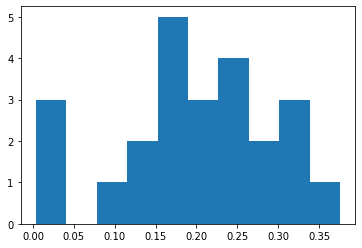

In [57]:
plt.hist(F_max)

In [58]:
tf.math.reduce_sum(model.lrs[1].F)

<tf.Tensor: shape=(), dtype=float32, numpy=28.996367>

In [59]:
b_max = model.lrs[1].b
b_max

<tf.Variable 'b:0' shape=(24,) dtype=float32, numpy=
array([-1.39534771e-02, -8.11492056e-02,  2.30627581e-02,  1.06229275e-01,
        7.36065395e-03, -7.20906183e-02, -1.64083038e-02, -8.71820152e-02,
       -6.31256551e-02,  1.54387951e-03, -1.02306843e-01,  6.62483927e-03,
       -1.78761631e-01, -4.03573597e-03, -1.05459790e-03, -1.94715019e-02,
       -2.98340563e-02,  6.84485276e-05,  8.16060521e-04,  7.12670386e-04,
       -4.17634733e-02, -8.96751694e-03,  2.04557691e-05,  2.13898369e-04],
      dtype=float32)>

(array([ 1.,  0.,  1.,  3.,  2.,  5., 10.,  1.,  0.,  1.]),
 array([-0.17876163, -0.15026253, -0.12176345, -0.09326436, -0.06476527,
        -0.03626618, -0.00776709,  0.020732  ,  0.04923109,  0.07773019,
         0.10622928], dtype=float32),
 <a list of 10 Patch objects>)

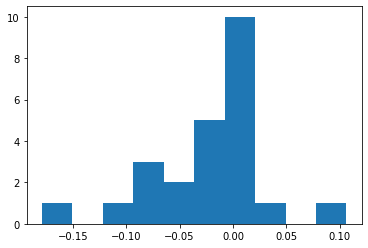

In [60]:
plt.hist(b_max)

In [61]:
epochs = 20
self_scaling_epochs = 0
batch_size = 256
min_new_neurons = 20

In [62]:
model.fit(X_train_norm, y_train, optimizer, epochs, self_scaling_epochs, batch_size, 
          min_new_neurons, validation_data=(X_test_norm, y_test))

##########################################################
Epoch 1/20
loss: 0.9274218678474426 - accuracy: 0.66866 - val_loss: 0.8334266543388367 - val_accuracy: 0.7071 - penalty: 0.0
hidden layer sizes: [66, 24, 26, 63, 99], total units: 278
##########################################################
Epoch 2/20
loss: 0.8430859446525574 - accuracy: 0.7004 - val_loss: 0.8132927417755127 - val_accuracy: 0.7135 - penalty: 0.0
hidden layer sizes: [66, 24, 26, 63, 99], total units: 278
##########################################################
Epoch 3/20
loss: 0.798242449760437 - accuracy: 0.71796 - val_loss: 0.7980955243110657 - val_accuracy: 0.7235 - penalty: 0.0
hidden layer sizes: [66, 24, 26, 63, 99], total units: 278
##########################################################
Epoch 4/20
loss: 0.76285719871521 - accuracy: 0.72686 - val_loss: 0.7911869883537292 - val_accuracy: 0.7231 - penalty: 0.0
hidden layer sizes: [66, 24, 26, 63, 99], total units: 278
################################

{'accuracy': [0.66866,
  0.7004,
  0.71796,
  0.72686,
  0.73504,
  0.74692,
  0.75974,
  0.76642,
  0.77572,
  0.78288,
  0.7909,
  0.79958,
  0.8075,
  0.81266,
  0.81936,
  0.82404,
  0.83142,
  0.83452,
  0.8396,
  0.84406],
 'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.92742187>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.84308594>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.79824245>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7628572>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7372441>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.71074235>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6807642>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6582094>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.63168514>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.6092785>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5863293>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.56340146>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.54291075>,
  <tf.Tensor: s

In [63]:
F_max = tf.math.reduce_max(tf.reshape(model.lrs[1].F, (-1, 24)), axis=0)
F_max

<tf.Tensor: shape=(24,), dtype=float32, numpy=
array([0.2852508 , 0.39062864, 0.26719773, 0.20736325, 0.2963995 ,
       0.42294604, 0.2650938 , 0.47059634, 0.21876326, 0.29584205,
       0.3412175 , 0.20349829, 0.19333054, 0.38822642, 0.22182624,
       0.2758319 , 0.2670268 , 0.15331937, 0.24605438, 0.3304207 ,
       0.04936865, 0.1445164 , 0.14679813, 0.14567664], dtype=float32)>

(array([1., 0., 4., 3., 3., 7., 2., 0., 3., 1.]),
 array([0.04936865, 0.09149142, 0.1336142 , 0.17573696, 0.21785973,
        0.2599825 , 0.30210528, 0.34422803, 0.3863508 , 0.42847356,
        0.47059634], dtype=float32),
 <a list of 10 Patch objects>)

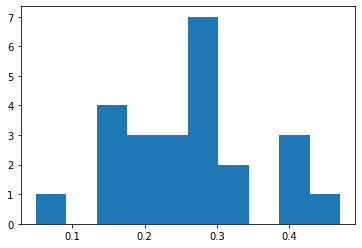

In [64]:
plt.hist(F_max)

In [65]:
tf.math.reduce_sum(model.lrs[1].F)

<tf.Tensor: shape=(), dtype=float32, numpy=54.194973>

In [66]:
b_max = model.lrs[1].b
b_max

<tf.Variable 'b:0' shape=(24,) dtype=float32, numpy=
array([-0.00747755, -0.08080523,  0.02618667,  0.11587684,  0.00518507,
       -0.0811644 , -0.02718006, -0.10063612, -0.07734868, -0.00177401,
       -0.1137526 ,  0.00489218, -0.21278912, -0.0204876 ,  0.01462507,
       -0.01291353, -0.03296454,  0.0084464 , -0.00314905, -0.00151894,
       -0.0637429 , -0.0200336 ,  0.01901927,  0.0081754 ], dtype=float32)>

(array([ 1.,  0.,  0.,  2.,  4.,  4., 10.,  2.,  0.,  1.]),
 array([-0.21278912, -0.17992252, -0.14705592, -0.11418933, -0.08132274,
        -0.04845614, -0.01558954,  0.01727705,  0.05014365,  0.08301024,
         0.11587684], dtype=float32),
 <a list of 10 Patch objects>)

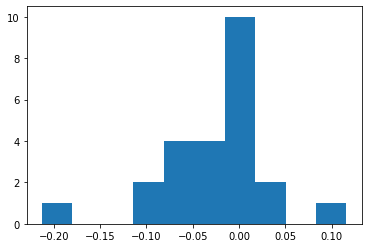

In [67]:
plt.hist(b_max)

# Misc

In [ ]:
# Temto model je na Cifar10 jiz pomerne vyladeny

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape=X_train_norm[0,:,:,:].shape, filters=96, kernel_size=(3,3), activation='selu', kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=2, activation='selu', kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), activation='selu', kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=2, activation='selu', kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='selu', kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
%%time

model.fit(X_train_norm, y_train, epochs=25, batch_size=256, validation_data=(X_test_norm, y_test))

Epoch 1/25
196/196 [==============================] - 9s 46ms/step - loss: 2.0276 - accuracy: 0.3617 - val_loss: 1.4487 - val_accuracy: 0.4768
Epoch 2/25
196/196 [==============================] - 9s 45ms/step - loss: 1.4076 - accuracy: 0.4938 - val_loss: 1.3187 - val_accuracy: 0.5150
Epoch 3/25
196/196 [==============================] - 9s 46ms/step - loss: 1.2646 - accuracy: 0.5483 - val_loss: 1.1942 - val_accuracy: 0.5702
Epoch 4/25
196/196 [==============================] - 9s 46ms/step - loss: 1.1380 - accuracy: 0.5945 - val_loss: 1.1212 - val_accuracy: 0.5984
Epoch 5/25
196/196 [==============================] - 9s 46ms/step - loss: 1.0255 - accuracy: 0.6347 - val_loss: 1.0245 - val_accuracy: 0.6363
Epoch 6/25
196/196 [==============================] - 9s 45ms/step - loss: 0.9390 - accuracy: 0.6672 - val_loss: 0.9999 - val_accuracy: 0.6479
Epoch 7/25
196/196 [==============================] - 9s 44ms/step - loss: 0.8667 - accuracy: 0.6939 - val_loss: 0.9372 - val_accuracy: 0.6731